# 컨볼루션 신경망
`작성자: 최원칠 강사`   
`traveler4d@gmail.com`

Tensorflow Keras를 활용한 모델 생성부터 학습 평가 과정까지의 실습 구조를 배웠습니다.   
지금까지 선형레이어를 기반으로 DNN 구조를 가진 모델을 활용하여 학습 및 평가를 했지만, 이미지와 같은 복잡한 데이터에서는 좋은 성능이 안나오기도 하였습니다.   

이렇게 데이터의 형태,특징에 따라 더욱 특징을 잘 찾아내고 효율적인 연산이 가능한 레이어들이 존재합니다.   
먼저 이미지에 특화된 컨볼루션 레이어에 대해 살펴봅니다.   

## 1. 컨볼루션 레이어

컨볼루션레이어 (convolution layer)는 이미지의 지역적인 특성을 뽑아내기에 최적화된 레이어입니다.   
기본적으로 이미지는 데이터의 크기가 크기 때문에 선형레이어에 입력 시 연산량과 파라미터가 기하급수적으로 커집니다.   
반면에, 컨볼루션 레이어는 커널크기 만큼의 가중치를 만들고 지역적으로 순회하면서 합성곱하여 파라미터수를 획기적으로 줄입니다.  

<img src="src/20240106_170855.png" width="600" align="center"/>

#### keras Conv2D
keras.layers 모듈에는 다양한 레이어가 있습니다.  
Conv2D 레이어는 2차원의 커널을 만들어 합성곱을 진행하는 컨볼루션레이어입니다.   
다음과 같은 인자를 설정해줍니다.    

- `filters` : 커널의 개수이자 출력결과의 채널수를 의미
- `kernel_size` : 커널의 사이즈 (x,y)
- `strides` : 커널이 이동할때의 픽셀 단위
- `padding` : 입력데이터의 둘레에 0을 채워넣음, 커널사이즈로 인한 이미지 크기변경이 없어짐
- `activation` : 활성화 함수 적용

Conv2D는 기본적으로 다음과 같은 모형을 입력으로 받습니다.   

    (batch, rows, cols, channels)   

패딩이 존재하는 경우 다음과 같은 출력 모형을 만듭니다.   
    
    (batch, rows/stride, cols/stride, filters)    

In [10]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers
import numpy as np

data_dir = './data/flower'
img_height = 32
img_width = 32
batch_size = 4

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                            
    validation_split=0.2,                
    subset="training",                   
    batch_size=batch_size,
    seed=42,                            
    image_size=(img_height, img_width),  
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4027 files belonging to 4 classes.
Using 3222 files for training.
Found 4027 files belonging to 4 classes.
Using 805 files for validation.


#### DNN 모델 파라이미터 확인

In [2]:
flatten = layers.Flatten()
dense1 = layers.Dense(64, activation="relu")
dense2 = layers.Dense(32, activation="relu")
dense3 = layers.Dense(16, activation="relu")
dense_out = layers.Dense(4)
softmax = layers.Softmax()

inputs = tf.keras.Input(shape=(32,32,3)) # shape는 데이터 개수를 의미하는 맨 앞의 축을 제외하고 입력
x = flatten(inputs)
x = dense1(x)
x = dense2(x)
x = dense3(x)
x = dense_out(x)
out = softmax(x)

model = tf.keras.Model(inputs=inputs, outputs=out)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() # int(인덱스) 형태의 라벨인 경우 
# complie
model.compile(optimizer=opt,
              loss=loss_fn,
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 64)                196672    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
 softmax (Softmax)           (None, 4)                 0     

#### CNN 모델 파라미터 확인

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

# (3,3) 사이즈의 커널, 8개의 필터, 1칸씩 건너뛰면서 합성곱, 패딩생성
conv_layer1 = layers.Conv2D(8, 3, 1, padding = 'same')
# (5,5) 사이즈의 커널, 16개의 필터, 2칸씩 건너뛰면서 합성곱, 패딩생성, relu
conv_layer2 = layers.Conv2D(16, 5, 2, padding = 'same', activation = 'relu')   
# (3,3) 사이즈의 커널, 32개의 필터, 2칸씩 건너뛰면서 합성곱, relu
conv_layer3 = layers.Conv2D(32, 3, 2, activation = 'relu') 

flatten = layers.Flatten()
dense1 = layers.Dense(32)
dense2 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((32,32,3))  # 입력데이터 : (batch, 32, 32, 3)
x = conv_layer1(inp)             # x : (batch, 32, 32, 8)  
x = conv_layer2(x)               # x : (batch, 16, 16, 16) 
x = conv_layer3(x)               # x : (batch, 7, 7, 32) 
x = flatten(x)                   # x : (batch, 7*7*32)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model = tf.keras.Model(inp, out, name = 'conv_model')
model.summary()


Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        3216      
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                50208     
                                                                 
 dense_5 (Dense)             (None, 4)                 1

> 선형레이어(Dense)로만 이루어진 DNN모델의 파라미터보다 약 1/4 의 파라미터를 가진 컨볼루션모델(CNN)을 구성했습니다.   
각 컨볼루션 레이어를 통과할때 데이터의 모형변화를 잘 관찰합니다.  

In [4]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs = 20, validation_data = val_ds)

Epoch 1/20
806/806 [==============================] - 4s 4ms/step - loss: 8.9747 - accuracy: 0.5475 - val_loss: 3.6730 - val_accuracy: 0.6534
Epoch 2/20
806/806 [==============================] - 2s 3ms/step - loss: 2.2577 - accuracy: 0.6664 - val_loss: 1.9642 - val_accuracy: 0.6472
Epoch 3/20
806/806 [==============================] - 2s 3ms/step - loss: 1.1880 - accuracy: 0.6915 - val_loss: 1.3444 - val_accuracy: 0.6534
Epoch 4/20
806/806 [==============================] - 2s 3ms/step - loss: 0.8281 - accuracy: 0.7309 - val_loss: 1.2193 - val_accuracy: 0.6770
Epoch 5/20
806/806 [==============================] - 2s 3ms/step - loss: 0.6377 - accuracy: 0.7831 - val_loss: 1.1535 - val_accuracy: 0.6957
Epoch 6/20
806/806 [==============================] - 3s 3ms/step - loss: 0.5166 - accuracy: 0.8203 - val_loss: 1.1683 - val_accuracy: 0.7006
Epoch 7/20
806/806 [==============================] - 2s 3ms/step - loss: 0.4266 - accuracy: 0.8507 - val_loss: 1.1146 - val_accuracy: 0.7193
Epoch 

In [5]:
loss_set = model.history.history

> CNN모델 파라미터가 적은것에 비해 DNN구조다 훨씬 빠르게 적은 손실을 나타내는것을 볼 수 있습니다.   
다만, 약 10에포크 이후로는 훈련세트의 loss는 줄지만 val_loss가 커지는것을 보아 과적합을 의심할 수 있습니다.

## 2. 과적합 방지 레이어
학습을 지속하다보면 학습데이터에만 가중치가 맞춰지는 과적합 현상을 피하기가 힘듭니다.   
하지만 정규화 방법, 가중치 초기화 방법등을 통해 과적합을 방지할수 있고 이는 keras의 레이어로 제공됩니다.   

- `BatchNormalization` : 입력 배치의 평균 및 표준 편차를 사용하여 출력을 정규화.
- `Dropout` : 인자로 입력된 확률만큼의 가중치를 0으로 초기화

In [32]:
import tensorflow as tf
from tensorflow.keras import layers

conv_layer1 = layers.Conv2D(8, 3, 1, padding = 'same')
conv_layer2 = layers.Conv2D(16, 5, 2, padding = 'same', activation = 'relu')   
conv_layer3 = layers.Conv2D(32, 3, 2, activation = 'relu') 

flatten = layers.Flatten()

bn = layers.BatchNormalization() # 배치 정규화 레이어
dr = layers.Dropout(0.2)         # 20퍼센트의 가중치를 0으로 초기화

dense1 = layers.Dense(32)
dense2 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((32,32,3))  
x = conv_layer1(inp)            
x = conv_layer2(x)              
x = conv_layer3(x)             
x = flatten(x)         
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model = tf.keras.Model(inp, out, name = 'conv_model')
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs = 20, validation_data = val_ds)

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 flatten_16 (Flatten)        (None, 1568)              0         
                                                                 
 batch_normalization_5 (Batc  (None, 1568)             6272      
 hNormalization)                                                 
                                                        

> 배치 정규화 레이어와 드롭아웃 레이어를 사용한 결과 val_loss가 지속적으로 상승하지 않는것을 확인합니다.     

## 3. 폴링 레이어

폴링레이어는 특정차원의 데이터의 크기를 최소한의 데이터손실로 줄여주는 레이어입니다.   
파라미터의 크기를 전반적으로 줄여줄수 있어 효율성을 높혀줍니다.  

- `MaxPooling` : 지정해준 커널의 차원,크기 만큼의 입력데이터중 가장 큰값을 1개의 픽셀로 설정하여 출력
- `AveragePooling` : 지정해준 커널의 차원,크기 만큼의 입력데이터의 평균을 1개의 픽셀로 설정하여 출력
- `GlobalPooling` : 하나의 축을 최대 또는 평균값으로 하나의 값으로 출력



In [34]:
import tensorflow as tf
from tensorflow.keras import layers

conv_layer1 = layers.Conv2D(8, 3, 1, padding = 'same')
conv_layer2 = layers.Conv2D(32, 5, 2, padding = 'same', activation = 'relu')   
conv_layer3 = layers.Conv2D(32, 3, 2, activation = 'relu') 

mp = layers.MaxPooling2D(pool_size=(2, 2)) # (2,2) 커널중 가장 큰값을 값으로
gp = layers.GlobalAveragePooling2D() # 2차원축 전체의 평균을 하나의 값으로

bn = layers.BatchNormalization() # 배치 정규화 레이어
dr = layers.Dropout(0.2)         # 20퍼센트의 가중치를 0으로 초기화
dense1 = layers.Dense(32)
dense2 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((32,32,3))  
x = conv_layer1(inp)            
x = conv_layer2(x)
x = mp(x)
x = conv_layer3(x)             
x = gp(x)         
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model = tf.keras.Model(inp, out, name = 'conv_model')
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs = 20, validation_data = val_ds)

Model: "conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 conv2d_52 (Conv2D)          (None, 16, 16, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_53 (Conv2D)          (None, 3, 3, 32)          4640      
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                               

> 모델의 큰 성능저하없이 파라미터를 줄일 수 있으므로 추가적인 레이어를 더 활용할 리소스 확보도 가능합니다.  

## 4. CNN 아키텍처

컨볼루션 레이어는 이미지데이터에서 탁월한 효과를 보여주며 가장 많이 발전한 딥러닝 아키텍처중에 하나입니다.   
이런 컨볼루션 레이를 기반으로 하는 고차원적인 다양한 모델 아키텍처가 존재합니다.   

- VGG : 3x3 Convolution레이어와 Pooling레이어를 깊게 쌓은 모델
- Resnet : BottleNeck 구조와 Skip을 적용한 컨볼루션 모델
- MobileNet : Depthwise Separable Convolution을 적용한 컨볼루션 모델
- EfficientNet : MobileNet 구조 기반으로 최적 스케일을 적용한 모델
- UNet : Convolution레이어을 역으로 하는 Up-sampling를 적용한 모델
- DCGAN : UNet 구조를 기반으로 생성모델, 분류모델 두개의 모델이 적대적으로 학습을 하는 모델

In [1]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers
import numpy as np

data_dir = './data/flower'
img_height = 64
img_width = 64
batch_size = 4

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,                            
    validation_split=0.2,                
    subset="training",                   
    batch_size=batch_size,
    seed=42,                            
    image_size=(img_height, img_width),  
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
class_names

Found 4027 files belonging to 4 classes.
Using 3222 files for training.
Found 4027 files belonging to 4 classes.
Using 805 files for validation.


['daffodil', 'sunflower', 'tulip', 'water_lily']

### MobileNet 사용해보기

keras처럼 딥러닝 모델에 대한 다양한 api를 제공하는 라이브러리는 이미 구성된 모델을 제공하기도 합니다.   
이때 가중치가 형성되지 않은 초기상태의 모델만 가져와 학습이 가능하고, 또는 이미 특정 데이터세트를 학습한 사전학습이 된 모델도 사용 가능합니다.  

***MobileNet*** 은 Depthwise Separable Convolution 방식을 통해 컬러이미지를 최소한의 파라미터로 효율적인 학습을 진행해주는 대표적인 CNN 아키텍처입니다.

In [2]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(64,64,3),
                                                    include_top=False,
                                                    weights='imagenet') 
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 32, 32, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 32, 32, 16)  64          ['Conv[0][0]']                   
 tion)                                                                             

                                                                                                  
 re_lu_4 (ReLU)                 (None, 8, 8, 72)     0           ['expanded_conv_1/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_1/project (Conv2  (None, 8, 8, 24)    1728        ['re_lu_4[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_1/project/BatchN  (None, 8, 8, 24)    96          ['expanded_conv_1/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 24)    0           ['expanded_conv_3/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_3/squeeze_excite  (None, 1, 1, 96)    2400        ['expanded_conv_3/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_4 (TFOpLa  (None, 1, 1, 96)    0           ['expanded_conv_3/squeeze_excite/
 mbda)                                                           Conv_1[0][0]']                   
          

 /Mul (Multiply)                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_4/project (Conv2  (None, 4, 4, 40)    9600        ['expanded_conv_4/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_4/project/BatchN  (None, 4, 4, 40)    160         ['expanded_conv_4/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_4/Add (Add)      (None, 4, 4, 40)     0           ['expanded_conv_3/project/BatchNo
                                                                 rm[0][0]',                       
          

 expanded_conv_6/expand (Conv2D  (None, 4, 4, 120)   4800        ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 4, 4, 120)   480         ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 4, 4, 120)   0           ['expanded_conv_6/expand/BatchNor
 ambda)                                                          m[0][0]']                        
                                                                                                  
 re_lu_16 (ReLU)                (None, 4, 4, 120)    0           ['tf.__operators__.add_11[0][0]']
          

                                                                                                  
 expanded_conv_7/depthwise (Dep  (None, 4, 4, 144)   3600        ['multiply_9[0][0]']             
 thwiseConv2D)                                                                                    
                                                                                                  
 expanded_conv_7/depthwise/Batc  (None, 4, 4, 144)   576         ['expanded_conv_7/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 4, 4, 144)   0           ['expanded_conv_7/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_20 

                                                                                                  
 re_lu_23 (ReLU)                (None, 2, 2, 288)    0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 2, 2, 288)   0           ['re_lu_23[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_12 (Multiply)         (None, 2, 2, 288)    0           ['expanded_conv_8/depthwise/Batch
                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 expanded_

 expanded_conv_9/squeeze_excite  (None, 1, 1, 144)   0           ['expanded_conv_9/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
                                                                                                  
 expanded_conv_9/squeeze_excite  (None, 1, 1, 576)   83520       ['expanded_conv_9/squeeze_excite/
 /Conv_1 (Conv2D)                                                Relu[0][0]']                     
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 1, 1, 576)   0           ['expanded_conv_9/squeeze_excite/
 ambda)                                                          Conv_1[0][0]']                   
                                                                                                  
 re_lu_27 (ReLU)                (None, 1, 1, 576)    0           ['tf.__operators__.add_22[0][0]']
          

 a)                                                                                               
                                                                                                  
 expanded_conv_10/squeeze_excit  (None, 2, 2, 576)   0           ['multiply_16[0][0]',            
 e/Mul (Multiply)                                                 'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_10/project (Conv  (None, 2, 2, 96)    55296       ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 2, 2, 96)    384         ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
          

In [3]:
from tensorflow.keras.applications import MobileNetV3Small

base_model = MobileNetV3Small(input_shape=(64,64,3),
                              include_top=False,
                              weights='imagenet') # imagenet 데이터셋으로 사전 학습이 진행
                                                  # None 으로 설정시 초기모델만 가져옴

# print(base_model.summary()) # show base_model summary

# 사전 학습 모델의 가중치 고정(프리징)
# base_model.trainable = False


global_pooling = layers.GlobalAveragePooling2D() #(3)
bn = layers.BatchNormalization()
dr = layers.Dropout(0.2)
dense1 = layers.Dense(64)
dense2 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((64,64,3))

x = base_model(inp)
x = global_pooling(x)
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)
model = tf.keras.Model(inp, out, name = 'MobileNet')
model.summary()


Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 MobilenetV3small (Functiona  (None, 2, 2, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 576)              2304      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                         

In [ ]:


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs=10, validation_data = val_ds)

Epoch 1/10


## 5. 데이터증강

모델의 성능을 향상시키는 방법중 가장 좋은 효율을 보여주는것은 바로 충분한 데이터양입니다.   
하지만 제한적인 이미지데이터를 가지고 있을 때, 다양한 이미지 데이터 증강 방식을 통해 마치 데이터의 양이 늘어나것과 같은 효과를 낼 수 있습니다.  

- Flip : 이미지 미러링 회전
- Rotation : 이미지를 특정 각도로 회전
- Zoom : 이미지를 확대 또는 축소

keras는 이런 이미지를 변환해주는 레이어 또한 제공이 됩니다.   
해당 레이어로 순전파를 구성하여 데이터세트에 `map()` 함수로 적용해줍니다.  

In [24]:
train_aug = tf.keras.Sequential([
        layers.RandomBrightness(0.2),
        layers.RandomFlip(),
        layers.RandomRotation(0.5),
        layers.RandomZoom(0.2,0.2)])

train_ds = train_ds.map(lambda x,y : (train_aug(x),y))
# train_ds = train_ds.prefetch(buffer_size=1000)

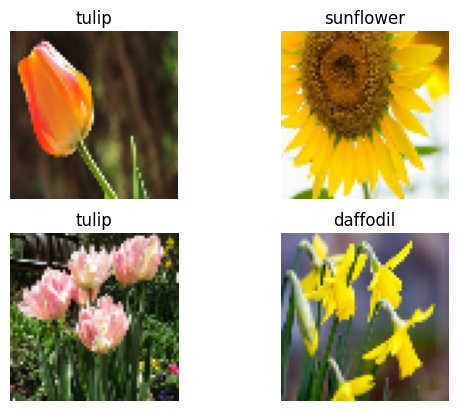

In [25]:
import matplotlib.pyplot as plt

for feature, label in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(feature[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [26]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(64,64,3),
                                                    include_top=False,
                                                    weights='imagenet') # imagenet 데이터셋으로 사전 학습이 진행
                                                                        # None 으로 설정시 초기모델만 가져옴

# print(base_model.summary()) # show base_model summary

global_pooling = layers.GlobalAveragePooling2D() #(3)
bn = layers.BatchNormalization()
dr = layers.Dropout(0.2)
dense1 = layers.Dense(64)
dense2 = layers.Dense(4)
softmax = layers.Softmax()

inp = tf.keras.Input((64,64,3))

x = base_model(inp)
x = global_pooling(x)
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)
model = tf.keras.Model(inp, out, name = 'MobileNet')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs=10, validation_data = val_ds)

Epoch 1/10
806/806 [==============================] - 24s 25ms/step - loss: 1.0465 - accuracy: 0.6499 - val_loss: 0.5981 - val_accuracy: 0.7938
Epoch 2/10
806/806 [==============================] - 19s 23ms/step - loss: 0.7870 - accuracy: 0.7303 - val_loss: 0.7402 - val_accuracy: 0.7901
Epoch 3/10
806/806 [==============================] - 19s 23ms/step - loss: 0.6690 - accuracy: 0.7694 - val_loss: 0.4114 - val_accuracy: 0.8571
Epoch 4/10
806/806 [==============================] - 17s 21ms/step - loss: 0.5591 - accuracy: 0.8011 - val_loss: 0.3328 - val_accuracy: 0.8870
Epoch 5/10
806/806 [==============================] - 19s 23ms/step - loss: 0.5234 - accuracy: 0.8110 - val_loss: 0.3465 - val_accuracy: 0.8671
Epoch 6/10
806/806 [==============================] - 19s 23ms/step - loss: 0.4904 - accuracy: 0.8312 - val_loss: 0.4219 - val_accuracy: 0.8621
Epoch 7/10
806/806 [==============================] - 19s 23ms/step - loss: 0.4437 - accuracy: 0.8470 - val_loss: 0.3973 - val_accuracy:

> 이미지 증강을 통해 이미지의 다양성을 확보하여 좀더 보편적인 모델을 만들수 있습니다.  

## [참고] 이미지 예측 프로세스

In [84]:
img = tf.io.read_file('data/flower_sample.jpg')
img = tf.io.decode_jpeg(img)
img = tf.image.resize(img, (64, 64), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
img = tf.reshape(image, (1,64,64,3))
img

<tf.Tensor: shape=(1, 64, 64, 3), dtype=uint8, numpy=
array([[[[  6,  80, 175],
         [  6,  80, 175],
         [  6,  80, 175],
         ...,
         [  0,  79, 174],
         [  0,  79, 174],
         [  0,  79, 174]],

        [[  2,  76, 171],
         [  2,  76, 171],
         [  2,  76, 171],
         ...,
         [  0,  79, 174],
         [  0,  79, 174],
         [  0,  79, 174]],

        [[  0,  73, 168],
         [  0,  73, 168],
         [  0,  73, 168],
         ...,
         [  0,  79, 174],
         [  0,  79, 174],
         [  0,  79, 174]],

        ...,

        [[ 87, 131, 206],
         [ 86, 130, 205],
         [ 85, 129, 204],
         ...,
         [ 78, 130, 214],
         [ 72, 128, 205],
         [ 80, 127, 205]],

        [[ 89, 133, 208],
         [ 88, 132, 207],
         [ 87, 131, 206],
         ...,
         [ 77, 125, 209],
         [ 77, 130, 206],
         [ 81, 128, 206]],

        [[ 91, 135, 210],
         [ 90, 134, 209],
         [ 90, 134, 

In [86]:
prd = model.predict(img)
prd

1/1 [==============================] - 0s 35ms/step


array([[9.748167e-11, 9.999223e-01, 7.776069e-05, 2.293319e-08]],
      dtype=float32)

In [65]:
ind = np.argmax(prd)
ind

1

In [66]:
class_names[ind]

'sunflower'

In [93]:
from PIL import Image
import numpy as np
img = Image.open('data/flower_sample.jpg')
img = img.resize((64, 64))
img = np.array(img)
img = np.reshape(img, (1, 64, 64, 3))
img.shape

(1, 64, 64, 3)

In [94]:
prd = model.predict(img)
ind = np.argmax(prd)
class_names[ind]

1/1 [==============================] - 0s 31ms/step


'sunflower'

In [98]:
import cv2
img = cv2.imread('data/flower_sample.jpg')
img = cv2.resize(img,(64,64))
img = np.reshape(img,(1,64,64,3))
img.shape

(1, 64, 64, 3)

In [99]:
prd = model.predict(img)
ind = np.argmax(prd)
class_names[ind]

1/1 [==============================] - 0s 19ms/step


'sunflower'

## [참고] 보틀넥 구조

2번의 컨볼루션을 축소된 채널로 유지하다가 3번째 컨볼루션 채널을 늘려 병목현상을 일으키는 구조   
기울기 소실을 줄이기 위해 이전 특성 텐서를 더해주는 skip 아키텍처를 추가 적용

In [100]:
import tensorflow as tf
from tensorflow.keras import layers

def data_augmentation(img, label): # (1)
    fliprotae = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2,0.2)])
    return fliprotae(img), label

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    './data/flower',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed = 1,
    validation_split=0.2,
    subset='both'
)

train_ds = train_ds.map(data_augmentation)
train_ds = train_ds.prefetch(buffer_size=1000) # (2)



def bt_block(inputs, filters):
    skipconv = layers.Conv2D(filters*4, 1, 2, use_bias=False)
    skipbn = layers.BatchNormalization()

    conv1 = layers.Conv2D(filters, 1, 1, use_bias=False) 
    conv2 = layers.Conv2D(filters, 3, 2, padding='same', use_bias=False)
    conv3 = layers.Conv2D(filters*4, 1, 1,use_bias=False) 

    bn1 = layers.BatchNormalization()
    bn2 = layers.BatchNormalization()
    bn3 = layers.BatchNormalization()

    active = layers.LeakyReLU()
    add = layers.Add()
    
    x = conv1(inputs)
    x = bn1(x)
    x = active(x)

    x = conv2(x)
    x = bn2(x)
    x = active(x)
    
    x = conv3(x)
    x = bn3(x)
    x = active(x)
    
    shortcut = skipconv(inputs)
    shortcut = skipbn(shortcut)
    
    x = x + shortcut
    return x

rescale = layers.Rescaling(1./127.5, offset=-1) 
global_pooling = layers.GlobalAveragePooling2D()
bn = layers.BatchNormalization()
dr = layers.Dropout(0.4)
dense1 = layers.Dense(64)
dense2 = layers.Dense(4)
softmax = layers.Softmax()


inp = tf.keras.Input((64,64,3))
x = rescale(inp)
x = bt_block(x, 32)
x = bt_block(x, 64)
x = bt_block(x, 64)
x = bt_block(x, 128)
x = bt_block(x, 128)

x = global_pooling(x)
x = bn(x)
x = dr(x)
x = dense1(x)
x = dense2(x)
out = softmax(x)

model = tf.keras.Model(inp, out, name = 'bt_cnn') # (4)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(train_ds, epochs=30, validation_data = val_ds) # (5)

Found 4027 files belonging to 4 classes.
Using 3222 files for training.
Using 805 files for validation.
Model: "bt_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling_5 (Rescaling)        (None, 64, 64, 3)    0           ['input_12[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 64, 64, 32)   96          ['rescaling_5[0][0]']            
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 64, 64, 32)  128         ['conv2d_4[0][0]']     

                                                                                                  
 conv2d_11 (Conv2D)             (None, 8, 8, 256)    65536       ['tf.__operators__.add_136[0][0]'
                                                                 ]                                
                                                                                                  
 batch_normalization_13 (BatchN  (None, 8, 8, 256)   1024        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_137 (TFOp  (None, 8, 8, 256)   0           ['leaky_re_lu_2[2][0]',          
 Lambda)                                                          'batch_normalization_13[0][0]'] 
                                                                                                  
 conv2d_16

Total params: 1,212,452
Trainable params: 1,203,108
Non-trainable params: 9,344
__________________________________________________________________________________________________
None
Epoch 1/30
101/101 [==============================] - 20s 175ms/step - loss: 1.2132 - accuracy: 0.6285 - val_loss: 1.2733 - val_accuracy: 0.2783
Epoch 2/30
101/101 [==============================] - 16s 160ms/step - loss: 0.7272 - accuracy: 0.7542 - val_loss: 1.0576 - val_accuracy: 0.5665
Epoch 3/30
101/101 [==============================] - 17s 166ms/step - loss: 0.5604 - accuracy: 0.8063 - val_loss: 0.7311 - val_accuracy: 0.7255
Epoch 4/30
101/101 [==============================] - 18s 178ms/step - loss: 0.4420 - accuracy: 0.8457 - val_loss: 0.5842 - val_accuracy: 0.8012
Epoch 5/30
101/101 [==============================] - 18s 175ms/step - loss: 0.3470 - accuracy: 0.8709 - val_loss: 0.5385 - val_accuracy: 0.8360
Epoch 6/30
101/101 [==============================] - 18s 179ms/step - loss: 0.3007 - accur

# 실습하기

#### [17-1] Grapevine 이미지 데이터 세트를 활용하여 포도 잎사귀의 병충해 판별 모델을 구축하고 평가 데이터와 학습 데이터에 대한 손실 그래프를 나타내세요, 이때 모델은 사전 훈련 모델 하나와 직접 구성한 CNN 모델 두개를 구성하고 학습하여 비교해봅니다

 #### 코랩으로 학습하기
1. Grapevine.zip 파일을 구글 드라이브에 업로드
2. colab 페이지 생성
3. 런타입 타입을 GPU로 변경
4. 다음 코드 실행

In [ ]:
# 코랩에서 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
# 기존 경로 변경(zip 파일이 있는 경로)
os.chdir('/content/drive/MyDrive/dataset')

In [ ]:
pwd

In [ ]:
import zipfile
import os

# Grapevine 폴더가 없으면 해당 경로에 zip 파일 압축 풀기
if not os.path.exists('Grapevine'):
  path = 'Grapevine.zip'
  f_zip = zipfile.ZipFile(path)
  f_zip.extractall('./Grapevine')
  f_zip.close()